In [82]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Flowers Dataset.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [83]:
import numpy as np
import os
import cv2
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [84]:
data_dir="/tmp/Flowers Dataset"

In [85]:
print(os.listdir("/tmp/Flowers Dataset"))

['tulip', 'daisy', 'rose', 'sunflower', 'dandelion']


In [86]:
batch_size=32
img_height=180
img_width=180

In [87]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2746 files belonging to 5 classes.
Using 2197 files for training.


In [88]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2746 files belonging to 5 classes.
Using 549 files for validation.


In [89]:
class_names=train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


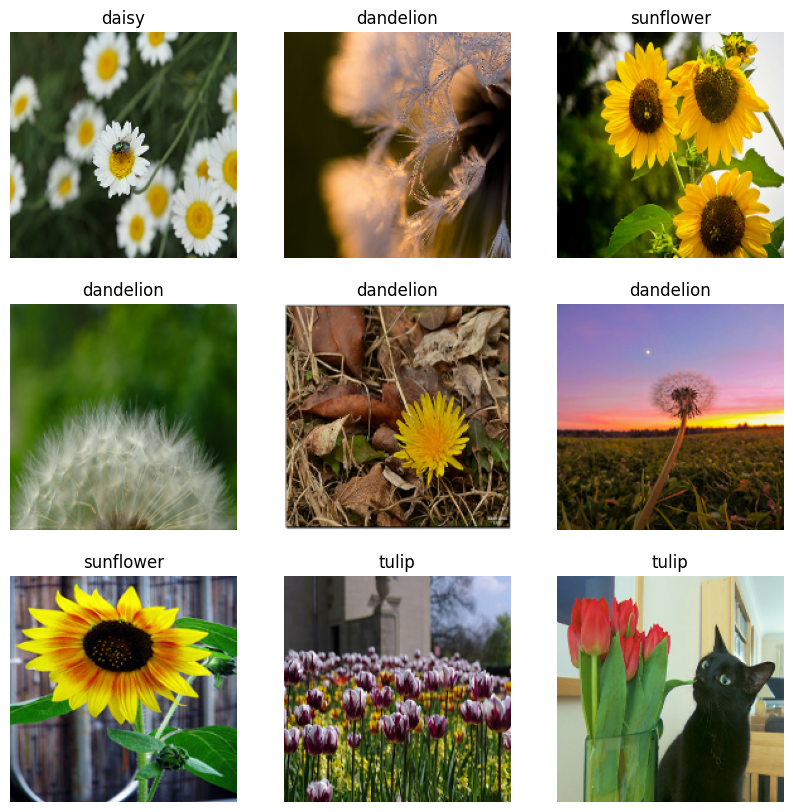

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [91]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [92]:
AUTOTUNE=tf.data.AUTOTUNE

train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [93]:
normalization_layer=layers.experimental.preprocessing.Rescaling(1./255)

In [94]:
normalized_ds=train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch=next(iter(normalized_ds))
first_image=image_batch[0]
#Notice the pixels values are now in '[0,1]'
print(np.min(first_image), np.max(first_image))

0.0 0.98434657


In [95]:
num_classes=5

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
])

In [96]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [97]:
epochs=50
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
69/69 [==============================] - 5s 41ms/step - loss: 1.3674 - accuracy: 0.4056 - val_loss: 1.1273 - val_accuracy: 0.5100
Epoch 2/50
69/69 [==============================] - 2s 28ms/step - loss: 1.0901 - accuracy: 0.5462 - val_loss: 1.0491 - val_accuracy: 0.6011
Epoch 3/50
69/69 [==============================] - 2s 28ms/step - loss: 0.9903 - accuracy: 0.6099 - val_loss: 1.0330 - val_accuracy: 0.6157
Epoch 4/50
69/69 [==============================] - 2s 27ms/step - loss: 0.8617 - accuracy: 0.6645 - val_loss: 0.8961 - val_accuracy: 0.6375
Epoch 5/50
69/69 [==============================] - 2s 30ms/step - loss: 0.7336 - accuracy: 0.7169 - val_loss: 0.9318 - val_accuracy: 0.6393
Epoch 6/50
69/69 [==============================] - 2s 28ms/step - loss: 0.6289 - accuracy: 0.7624 - val_loss: 1.0579 - val_accuracy: 0.6393
Epoch 7/50
69/69 [==============================] - 2s 25ms/step - loss: 0.5022 - accuracy: 0.8061 - val_loss: 0.9607 - val_accuracy: 0.6466
Epoch 8/50
69

Text(0.5, 1.0, 'Training and Validation Loss')

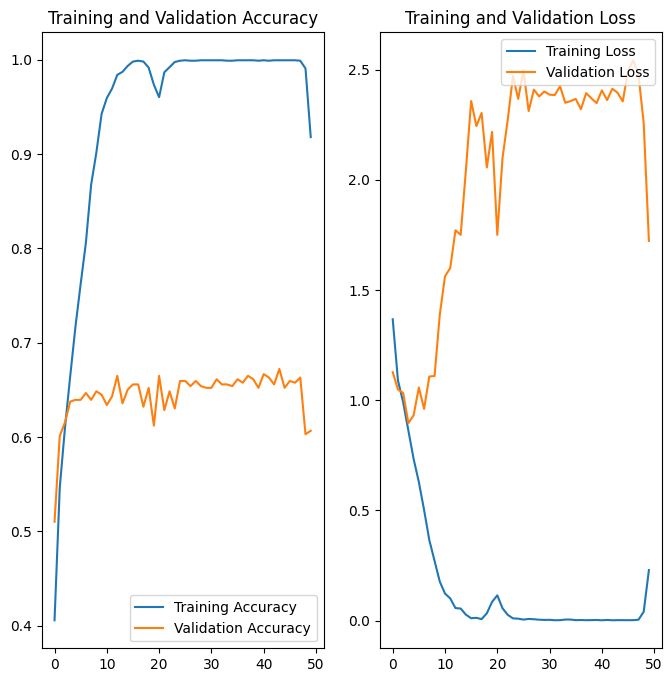

In [98]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [99]:
data_augmentation=keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal",
                                                     input_shape=(
                                                        img_height,
                                                        img_width,
                                                        3
                                                     )),

        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),

    ]
)

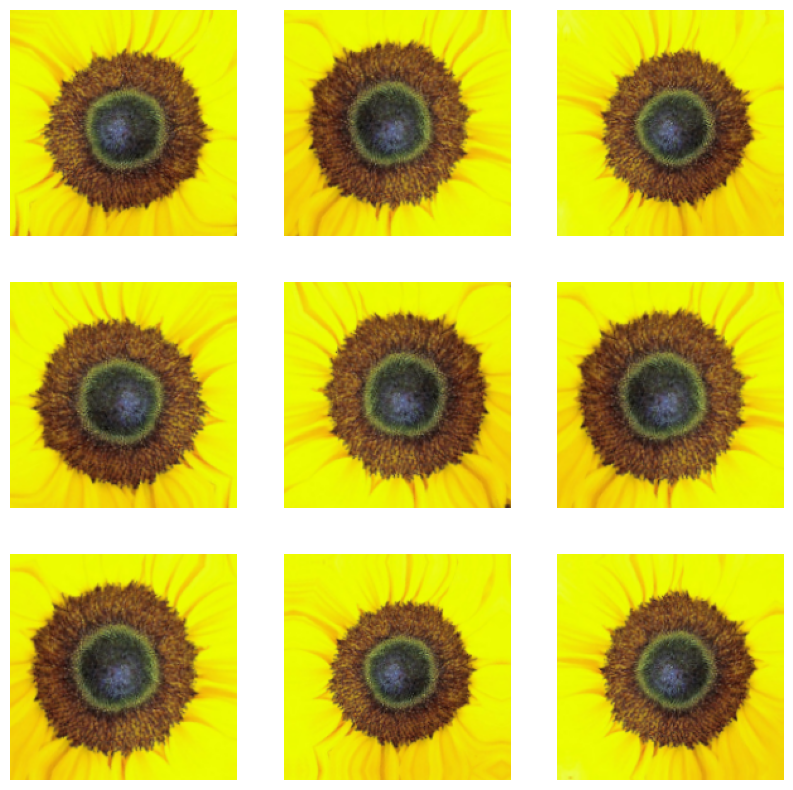

In [100]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images=data_augmentation(images)
    ax=plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [102]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

Saving Image_1.jpg to Image_1 (1).jpg


In [103]:
#daisy=0, dandelion=1, rose=2, sunflower=3, tulip=4

for fn in uploaded.keys():
  #predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(180,180))

  x=image.img_to_array(img)
  test_img=np.expand_dims(x, axis=0)

  result=model.predict(test_img)
  pred=np.argmax(result) #get the index of max value

  print(pred)

1/1 [==============================] - 0s 124ms/step
3
